In [1]:
%pylab notebook
from importlib import reload
import pandas as pd
from scipy.optimize import curve_fit
import scipy.ndimage as flt
from scipy.stats import linregress
from matplotlib import mlab as mlab
import xarray as xr
import json
import scipy
from astropy.table import Table, Column, MaskedColumn
from astropy.io import ascii
from scipy.signal import butter, filtfilt, lfilter
from urllib.request import urlopen

def linear_fit(x, a, b):
    return a*x+b

def my_butter_filter(cutoff, fs, order = 32):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def my_lowpass_filter(data, cutoff, fs, order = 32):
    #scipy filtfilt
    b, a = my_butter_filter(cutoff, fs, order = order)
    return filtfilt(b, a, data)

 #FS = 1 / dsp.get_sampling_step(current),... tj. 1/T
FS = 1000.

def lowpasss(t, s, cutoff, vb=False, order = 3):

    f_sample = (1./(t[1]-t[0]))
    sigma = f_sample/(2.*np.pi*cutoff)
   
    return flt.gaussian_filter1d(s, sigma)

def my_bandstop_filter(data, lowcut, highcut, fs, order = 32):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut /nyq
    
    b, a = butter(order, [low, high], btype = 'bandstop')
    return filtfilt(b, a, data)
    
    

def bin_average(current, voltage, binsize, vb=False):
    
    min_voltage = np.nanmin(voltage)
    max_voltage = np.nanmax(voltage)
    
    if binsize == 0.: return {'I': current, 'V': voltage} #binsize zero will returned the input values
        
    voltage_bins = np.arange(min_voltage + 0.5*binsize, max_voltage - 0.5*binsize, binsize)
    current_bins_mean = np.empty_like(voltage_bins)
    voltage_bins_mean = np.empty_like(voltage_bins)
    current_bins_std = np.empty_like(voltage_bins)
    voltage_bins_std = np.empty_like(voltage_bins)
    
    for i, voltage_bin in enumerate(voltage_bins):
        bin_condition = (voltage_bin + 0.5 * binsize > voltage) & (voltage > voltage_bin - 0.5 * binsize)
        current_bins_mean[i] = np.mean(current[bin_condition])
        voltage_bins_mean[i] = np.mean(voltage[bin_condition])
        current_bins_std[i] = np.std(current[bin_condition])
        voltage_bins_std[i] = np.std(voltage[bin_condition])
        

    current_bins_std[current_bins_std == 0.] = np.nanmean(current_bins_std) #zero error can happen but is unphysical.
    voltage_bins_std[voltage_bins_std == 0.] = np.nanmean(voltage_bins_std)
    
    return {'I': current_bins_mean, 'V': voltage_bins_mean, 'I_err': current_bins_std, 'V_err': voltage_bins_std}

class Interpolator(object):

    def __init__(self, x, y, kind = 'linear'):
        """
        Construct 1 dimensional interpolator for function of kind f(x)=y
        
        :param x: x coordinates, array
        :param y: y coordinates, array
        :param kind: method of interpolation, default linear
        """
        self.interpolator = scipy.interpolate.interp1d(x, y, kind = kind)
        
    def interpolate(self, x):
        """
        Interpolates new values of y for values of x for f(x)=y
        
        :param x: x coordinates, array
        :retun: intepolated values of y, array
        """
        return self.interpolator(x)
    
    def mean_of_interpolate(self, x):
        """
        Interpolates new values of y for values of x for f(x)=y and calculates their mean.
        
        :param x: x coordinates, array
        :return: mean value of interpolates values of y
        """
        interval = self.interpolate(x)
        return np.mean( interval )


class Intervals(object):
    
    def __init__(self, interval, x, y, kind = 'linear'):
        """
        Costructs interval with 1 dimensional interpolator for function of kind f(x)=y, where interval is x.
        
        :param interval: interval of all possible values, array
        :param x: x coordinates, array
        :param y: y coordinates, array
        :param kind: method of interpolation, default linear
        """
        self._interpolator = Interpolator(x, y, kind = kind)
        self._interval = interval
    
    def interval(self, begin, end):
        """
        Returns interval of values between begin and end.
        
        :param begin: Smallest possible value of interval.
        :param end: Largest possible value of interval.
        """
        return self._interval[ 
            np.where(
                np.logical_and(
                    begin <= self._interval, self._interval <= end
                )
            ) 
                      ]
    
    def interpolate_for_interval(self, begin, end):
        """
        Interpolates new values of y for values of x for f(x)=y
        for interval between begin and end.
        
        :param begin: Smallest possible value of interval.
        :param end: Largest possible value of interval.
        :retun: intepolated values of y within interval, array
        """
        return self._interpolator.interpolate(self.interval(begin, end))
    
    def interpolate_mean_for_interval(self, begin, end):
        """
        Interpolates new values of y for values of x for f(x)=y and calculates their mean
        for interval between begin and end.
        
        :param begin: Smallest possible value of interval.
        :param end: Largest possible value of interval.
        :return: mean value of interpolates values of y within interval
        """
        return self._interpolator.mean_of_interpolate(self.interval(begin, end))


def nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx
    

##############FOURIER TRANSFORMATION SHOT CHECK################
#1. normal method 
def freq_gen(t, Fs=FS):   #FS default value change to freq of data aquisition
    n = len(t)
    half = int(n/2)
    k = np.arange(n)
    T = n/Fs
    f = k/T
    f_half = f[0:half]
    return f_half

#2. averaged method
from scipy.signal import welch
def my_welch(signals, nperseg = 2048, fs = FS): 
#FS sampling frq, nperseg is window lenght 
#(The bigger the box the lower frequency/wavelenght we can see)
    frequencies, spectras = welch(signals, fs = fs, \
                nperseg = nperseg, scaling = 'density')
    return frequencies, spectras

def running_mean(l, N):
    #he running mean is a case of the mathematical operation of convolution. 
    #For the running mean, you slide a window along the input and compute the mean of the window's contents.
    # Also works for the(strictly invalid) cases when N is even.
    if (N//2)*2 == N:
        N = N - 1
    front = np.zeros(N//2)
    back = np.zeros(N//2)
    for i in range(1, (N//2)*2, 2):
        front[i//2] = np.convolve(l[:i], np.ones((i,))/i, mode = 'valid')
    for i in range(1, (N//2)*2, 2):
        back[i//2] = np.convolve(l[-i:], np.ones((i,))/i, mode = 'valid')
    return np.concatenate([front, np.convolve(l, np.ones((N,))/N, mode = 'valid'), back[::-1]])


Populating the interactive namespace from numpy and matplotlib


In [2]:
shot_number = '33445'
radial_probe_position = 65

# lp a bpp sonda
lp = pd.read_csv(urlopen('http://golem.fjfi.cvut.cz/shots/' + shot_number +'/DASs/PetiSonda/4-LPfloat.csv'),names = ['t','V'])
lp.t = 1e3*lp.t
time_ax = lp.t
lp_V = lp.V *178

## #offsetremoval
tt=1
time_ax =np.array(time_ax)

OffsetLP = np.mean(lp_V[10:nearest(time_ax, tt)])
print('ofset_lp: '+str(OffsetLP))
Vfl_LP = lp_V - OffsetLP

#BPP
current_BPP = pd.read_csv(urlopen('http://golem.fjfi.cvut.cz/shots/' + shot_number +'/DASs/PetiSonda/2-BPPcur.csv'),names = ['t','I'])
bpp_time = 1e3*current_BPP.t
current = current_BPP.I/22 ##odpor bol 22 
voltage_BPP = pd.read_csv(urlopen('http://golem.fjfi.cvut.cz/shots/' + shot_number +'/DASs/PetiSonda/3-BPPvolt.csv'),names = ['t','V'])
voltage_time = 1e3*voltage_BPP.t
voltage = 178*voltage_BPP.V

# zakladni parametry plazmatu
Bt = pd.read_csv(urlopen('http://golem.fjfi.cvut.cz/shots/' + (shot_number) +'/DASs/StandardDAS/BtCoil_integrated.csv'),names = ['t','B'])
Bt.t = 1000*Bt.t
Ip = pd.read_csv(urlopen('http://golem.fjfi.cvut.cz/shots/' + (shot_number) +'/DASs/StandardDAS/RogowskiCoil_integrated.csv'),names = ['t','I'])
Ip.t = 1000*Ip.t
Ip.I = (Ip.I/1000)
Uloop = pd.read_csv(urlopen('http://golem.fjfi.cvut.cz/shots/' + (shot_number) +'/DASs/StandardDAS/LoopVoltageCoil_raw.csv'),names = ['t','V'])
Uloop.t = 1000*Uloop.t


ofset_lp: -0.8277686533301768


In [3]:
f_sample = (1./(bpp_time[1]-bpp_time[0]))
print('DAS freqency = '+ str(f_sample) + ' MHz') ### = 1MHz
FS

DAS freqency = 999.9755859374997 MHz


1000.0

<IPython.core.display.Javascript object>


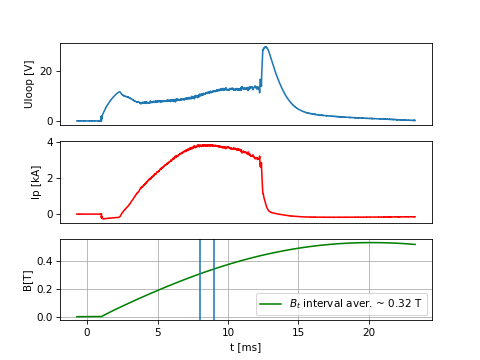

alpha calculated for present average magetic field=  0.2381446545700001


In [4]:
fig,ax = plt.subplots(3)
fromm = 8
untill = 9
ax[0].plot(Uloop.t,Uloop.V)
ax[0].set_xticks([])
ax[0].set_ylabel('Uloop [V]')

ax[1].plot(Ip.t,Ip.I,color = 'red')
ax[1].set_xticks([])
ax[1].set_ylabel('Ip [kA]')

st = nearest(Bt.t , fromm)
ed = nearest(Bt.t , untill)
ax[2].plot(Bt.t,Bt.B, color = 'green', label = '$B_t$ interval aver. ~ '+str('{0:4.2f}'.format((Bt.B[st] + Bt.B[ed])/2))+' T')
ax[2].legend()
ax[2].set_xlabel('t [ms]')
ax[2].set_ylabel('B[T]')
ax[2].axvline(x = fromm)
ax[2].axvline(x = untill)
ax[2].grid()

B_tor = (Bt.B[st] + Bt.B[ed])/2
alpha_lp = 2.7
alpha_calc = alpha_lp - (1.89*B_tor + 1.85) 
#print('alpha used =  ' + str(alpha))
print('alpha calculated for present average magetic field=  ' + str(alpha_calc))

In [6]:
alpha = alpha_calc
def ivchar_fit(v, Ti, R, Vf, Isat):
    return np.exp(alpha)* Isat * (1 + R*(v-Vf)) - Isat * np.exp((Vf - v) / Ti)

#makes a 3-param fit with fixed Vp (eats potential gives 3p fit)###########
def Afterburner(Vf):
    def ivchar_fit(v, Ti, R, Isat):
        return np.exp(alpha)* Isat * (1 + R*(v-Vf)) - Isat * np.exp((Vf - v) / Ti)
    return ivchar_fit

# for applications (eats Voltage and params gives I)
def ivchar_fit_Weighted(v, Ti, R, Isat):
        return np.exp(alpha)* Isat * (1 + R*( v-rrpopt2[2])) - Isat * np.exp((rrpopt2[2]-v ) / Ti)
    
def ivchar_fit_Unweighted(v, Ti, R, Isat):
        return np.exp(alpha)* Isat * (1 + R*(v-rrpopt[2] )) - Isat * np.exp(( rrpopt[2]-v) / Ti)

####condition = (150+rrpopt2[2]) < 3*crrpopt2[0] ####
def Afterburner_1(Vf):
        def ivchar_fit_2p(v, Ti, Isat):
            return np.exp(alpha)* Isat * (1) - Isat * np.exp(( Vf-v) / Ti)
        return ivchar_fit_2p

def Afterburner_2(Vf):
        def ivchar_fit_3p(v, Ti, R, Isat):
            return np.exp(alpha)* Isat * (1 + R*(v-Vf )) - Isat * np.exp((Vf-v) / Ti)
        return ivchar_fit_3p

def Rzero(condition): 
    if condition:
        print('Rzero')
        return Afterburner_1
    else:
        print('4-param')
        return Afterburner_2
    


def q_curve_fit(boundss, *args, **kwargs):
    _len = len(boundss[0])
    if _len == 3:
        res_11, res_22 = curve_fit(*args, **kwargs)
        return np.asarray([res_11[0], res_11[1], res_11[2]]) , np.asarray([np.sqrt(res_22[0][0]), np.sqrt(res_22[1][1]) ,np.sqrt(res_22[2][2])])
    
    elif _len == 2:
        res_1, res_2 = curve_fit(*args, **kwargs)
        #return np.asarray([res_1[0], 0, res_1[1]]), res_2
        return np.asarray([res_1[0], 0, res_1[1]]) , np.asarray([np.sqrt(res_2[0][0]), 0 ,np.sqrt(res_2[1][1] )])


# Probes

<IPython.core.display.Javascript object>


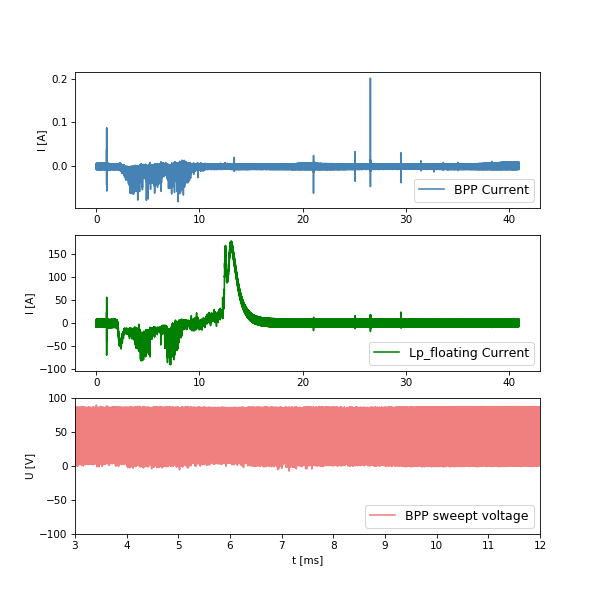

In [7]:
fig,ax = plt.subplots(3 , figsize = (8,8) ,sharex= False)
ax[0].plot(bpp_time, current , color= 'steelblue', label = 'BPP Current')
ax[0].set_ylabel('I [A]')
#ax[0].set_ylim(-0.02,0.02)
ax[0].legend(loc= 'lower right' ,fontsize = 12)

#ax[1].plot(bpp_time, lp_I , color= 'Darkkhaki', label = 'lp Current original')
ax[1].plot(time_ax, Vfl_LP , color= 'green', label = 'Lp_floating Current')
ax[1].set_ylabel('I [A]')
#ax[1].set_ylim(-6,6)
ax[1].legend(loc= 'lower right' ,fontsize = 12)

ax[2].plot(bpp_time, voltage, color= 'lightcoral', label = 'BPP sweept voltage')
ax[2].set_xlabel('t [ms]')
ax[2].set_ylabel('U [V]')
ax[2].set_xlim(3,12)
ax[2].set_ylim(-100,100)
ax[2].legend(loc= 'lower right' ,fontsize = 12)



In [77]:
### do 80 kvoli limitacii pristroja 90V nabuduce + DC zdroj -->150V

<IPython.core.display.Javascript object>


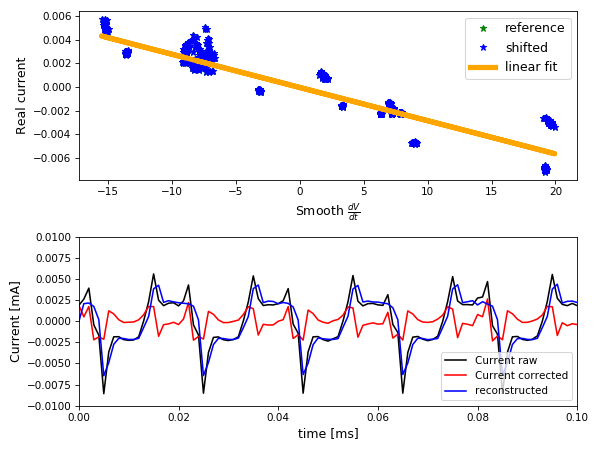

In [8]:
# ------------------------------------------------------------------------------------------------------------
# ---------------------------------- Change this -------------------------------------------------------------

shift0 = 0            #shift the array to find the relative phase
shift1 = 0

tcap = 1            # end of the unperturbed voltage signal

# ------------------------------------------------------------------------------------------------------------

lowpass= 370          #10x frequency estimate

fig, ax =plt.subplots(2,1,figsize=(8, 6))
plt.grid()

artificial = np.diff(my_lowpass_filter(voltage[bpp_time< tcap], lowpass, FS, order = 2))

real = my_lowpass_filter(current[bpp_time< tcap][:-1], lowpass, FS, order = 2)                   

ax[0].plot(np.roll(a=artificial, shift=shift0), real, linestyle='None', Marker='*', color='g', label='reference')
ax[0].plot(np.roll(a=artificial, shift=shift1), real, linestyle='None', Marker='*', color='b', label='shifted')

popt, pcov = curve_fit(linear_fit, artificial, real)

ax[0].plot(artificial, linear_fit(artificial, popt[0], popt[1]), linewidth=5, color='orange', label = 'linear fit')
#plt.ylim(0., 0.008)
ax[0].set_xlabel(r'Smooth $\frac{{dV}}{{dt}}$', fontsize=12)
ax[0].set_ylabel('Real current', fontsize=12)
ax[0].legend(fontsize=12)

x = np.diff(my_lowpass_filter(voltage, lowpass, FS, order = 2))
x = np.diff(voltage)
###############SHIFTING ##############################################
reconstr_shift_right =  list(linear_fit(x, popt[0], popt[1]))
reconstr_shift_right.insert(0, 0.0)
reconstructed_shifted = reconstr_shift_right[:-1]

# reconstr_shift_left = list(linear_fit(x, popt[0], popt[1]))
# reconstr_shift_left.append(0.0)
# reconstructed_shifted = reconstr_shift_left[1:]

reconstructed_noShift = linear_fit(x, popt[0], popt[1])
###############SHIFTING ##############################################
current_corrected = current[:-1]-reconstructed_shifted

ax[1].grid()
ax[1].plot(bpp_time, current, 'k', label='Current raw')
ax[1].plot(bpp_time[:-1], current_corrected, 'red', label='Current corrected')
ax[1].plot(bpp_time[:-1], reconstructed_shifted, 'b', label='reconstructed')

###############SHIFTING RESULT COMPARATION##############################################
# ax[1].plot(bpp_time[:-1], current[:-1]-reconstructed_noShift, 'red', label='Current corrected')
# ax[1].plot(bpp_time[:-1], current[:-1]-reconstructed_shifted, 'green', label='Current corrected SHIFTED')
########################################################################################

ax[1].legend()
ax[1].set_xlabel('time [ms]', fontsize=12)
ax[1].set_ylabel('Current [mA]', fontsize=12)
# ax[1].set_xlim(0.1, 0.4)
ax[1].set_xlim(0.0 , 0.1)
ax[1].set_ylim(-0.01, 0.01)

# ax[2].plot(bpp_time[bpp_time< tcap][:-1],artificial)
# # ax[2].plot(bpp_time[bpp_time< tcap][:-1], artificial)
# ax[2].set_xlim(0.0 , 0.1)
# ax[2].set_ylim(-0.01, 0.01)
plt.tight_layout()
plt.savefig(str(shot_number)+'cleaning1.png')

In [79]:
lowpass

370

<IPython.core.display.Javascript object>


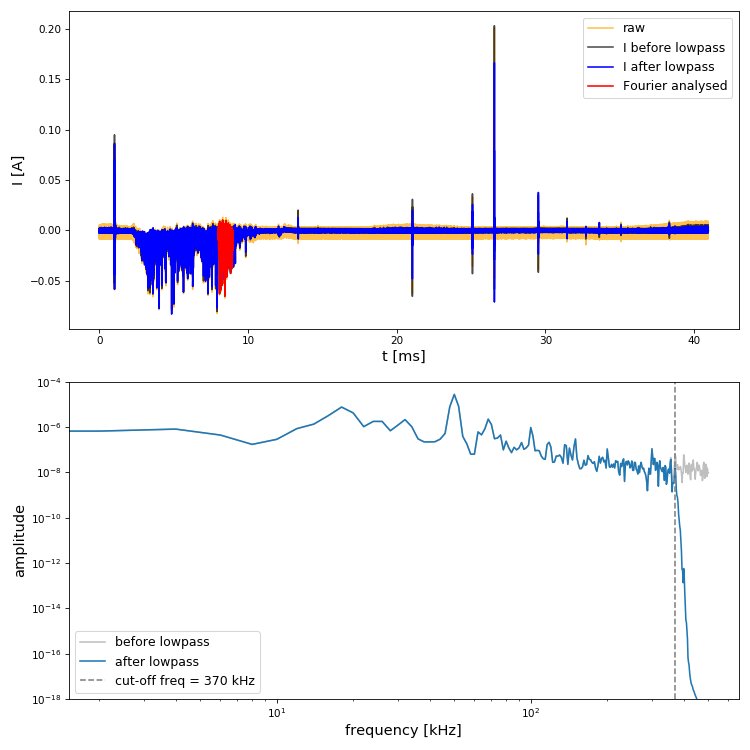

In [9]:
smooth_voltage = my_lowpass_filter(voltage, lowpass, FS, order = 10)
V = smooth_voltage[:-1]
Id = current_corrected
trt = bpp_time[:-1]
t = np.array(trt)

fourier_from = nearest(trt,8)
fourier_until = nearest(trt,9 )

I = my_lowpass_filter(Id, 370, FS, order = 10 ) # order32 like default for compass(only current),   For 1kHz -> 200 50kHz->500

#PLOTING:
fig, ax = plt.subplots(2,1, sharex= False, figsize =(10,10))
ax[0].plot(bpp_time, current, label=r'raw', color='orange', alpha=.7)
ax[0].plot(t, Id, label='I before lowpass', color='black', alpha=.7)
ax[0].plot(t, I, label='I after lowpass', color='blue')
ax[0].plot(t[fourier_from:fourier_until], Id[fourier_from:fourier_until], label=r'Fourier analysed', color='red', alpha=1)

ax[0].legend(fontsize = 12)
ax[0].set_xlabel('t [ms]', fontsize=14)
ax[0].set_ylabel('I [A]', fontsize=14)
#ax[0].set_xlim(913.92, 914.)
#ax[0].set_ylim(-0.01, 0.02)
#ax[0].set_ylim(-0.01, 0.02)
fffff, sssss = my_welch(Id[fourier_from:fourier_until], nperseg=500)
fff, sss = my_welch(I[fourier_from:fourier_until], nperseg=500)
ax[1].loglog(fffff, sssss, color= 'gray', alpha = 0.5, label= 'before lowpass')
ax[1].loglog(fff, sss, label= 'after lowpass' )
# ax[1].set_ylim(10**(-13), 10**(-6))
ax[1].set_ylim(10**(-18), 10**(-4))
# ax[1].set_xlim(0, 5*10**(6))
ax[1].axvline(370, lineStyle= 'dashed' , color = "gray", label = 'cut-off freq = ' +str(lowpass)+' kHz')
ax[1].set_xlabel('frequency [kHz]', fontsize=14)
ax[1].set_ylabel('amplitude', fontsize=14)
plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig(str(shot_number)+'cleaning2.png')

<IPython.core.display.Javascript object>


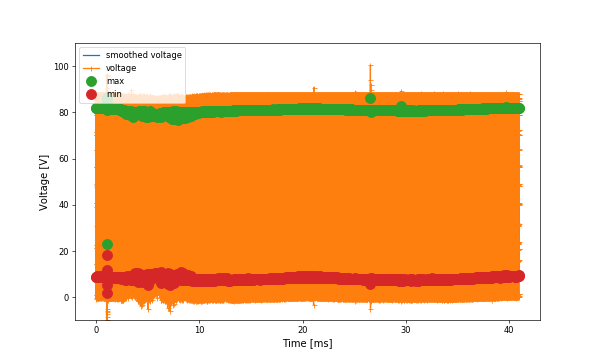

In [10]:
VAchar_voltage_smoothed=running_mean(V,5)
VAchar_current_smoothed=running_mean(I,5)

ylim_min=np.min(VAchar_current_smoothed)
ylim_max=np.max(VAchar_current_smoothed)
xlim_min=np.min(VAchar_voltage_smoothed)
xlim_max=np.max(VAchar_voltage_smoothed)

data=VAchar_voltage_smoothed
extrems_tmp = (np.diff(np.sign(np.diff(data))).nonzero()[0] + 1) # local min+max
minima = ((np.diff(np.sign(np.diff(data))) > 0).nonzero()[0] + 1) # local min
maxima = ((np.diff(np.sign(np.diff(data))) < 0).nonzero()[0] + 1) # local max

# Sometimes double extrems appear, removal:
#print extrems
extrems=[]
for i in range(len(extrems_tmp)-1): 
    if abs(extrems_tmp[i]-extrems_tmp[i+1])>10: 
        extrems.append(extrems_tmp[i])


#np.savetxt('Data/extrems',extrems, fmt="%s")
#np.savetxt('Data/minima',minima, fmt="%s")
#np.savetxt('Data/maxima',maxima, fmt="%s")

# graphical output...
from pylab import *
plt.figure(figsize=(10,6), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(t,data , label = 'smoothed voltage')
plt.plot(t,V, '-+', label = 'voltage')
plt.plot(t[maxima], data[maxima], "o", label="max",markersize=12)
plt.plot(t[minima], data[minima], "o", label="min",markersize=12)
plt.ylabel('Voltage [V]', fontsize = 12)
plt.xlabel('Time [ms]',fontsize = 12)
#plt.title('Maxima and minima identification')
plt.legend(fontsize = 10)

plt.ylim( -10.,110)


interval_pivots =np.concatenate([minima, maxima])
interval_pivots.sort()
interval_pivots = t[interval_pivots]
#plt.xlim(interval_pivots[192],interval_pivots[196])

In [82]:
interval_pivots[1100]

10.983268146194977

In [10]:
nearest(interval_pivots,8.672)

869

In [11]:
Ti_filt

NameError: name 'Ti_filt' is not defined

In [ ]:
time_filter

# Example of fit

D:\Programy\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
D:\Programy\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
D:\Programy\lib\site-packages\numpy\core\_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
D:\Programy\lib\site-packages\numpy\core\_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
D:\Programy\lib\site-packages\numpy\core\_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
D:\Programy\lib\site-packages\ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in greater_equal
D:\Programy\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in greater_equal
D:\Programy\lib\site-packages\ipyk

4-param
4-param


<IPython.core.display.Javascript object>


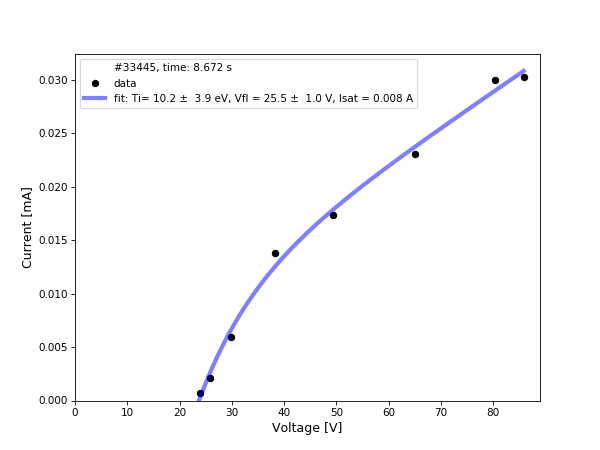

In [11]:
iv_start = 869
index_to_time = interval_pivots[iv_start]
time_bin = 15
Ti_lobound= 0
Ti_upboud = 80
Vp_lobound = 0
Vp_upbound = 80
R_lobound = 0
R_upbound = 1
Isat_lobound = -0.5
Isat_upbound = 0
MAX_voltage = 90

lobound = [Ti_lobound, R_lobound, Vp_lobound, Isat_lobound]       # fit lower bound for Ti, R, Vf, Isat
upbound = [Ti_upboud, R_upbound, Vp_upbound, Isat_upbound]    # fit upper bound for Ti, R, Vf, Isat
binsize = 5
# ------------------------------------------------------------------------------------------------------------

iv_stop  = iv_start + 1 # +1 perioda # LOL

cut_err = (interval_pivots[iv_start-time_bin//2] < t) & (t < interval_pivots[iv_start+time_bin//2])
cut_dat = (interval_pivots[iv_start] < t) & (t < interval_pivots[iv_stop])
cut_V = (0 < V) & (V < MAX_voltage)
cut_I = (I < 0.0)

I_short = I[cut_dat & cut_I & cut_V]
V_short = V[cut_dat & cut_I & cut_V]
I_long  = I[cut_err & cut_I & cut_V]
V_long  = V[cut_err & cut_I & cut_V]


binned_data = bin_average(I_long, V_long, binsize) # Compute the standard deviations for each bin

verrs = binned_data['V_err'] # voltage stds
ierrs = binned_data['I_err'] # current stds
vbins = binned_data['V']    # un-center the bins
ibins = binned_data['I'] 


current_err = np.ones_like(I_short) # create an array of ones with the same size as I
voltage_err = np.ones_like(V_short) # which is also the size of V, so both are the same size

for i, vbin in enumerate(vbins): # iterate on the bins
    current_err[V_short >= vbin] = ierrs[i] 
    voltage_err[V_short >= vbin] = verrs[i]
    
    
# This is the unweighted fit
popt, pcov = curve_fit(ivchar_fit, V_short, I_short, bounds=(lobound, upbound))
# This is the weighted fit
popt2, pcov2 = curve_fit(ivchar_fit, V_short, I_short, bounds=(lobound, upbound), sigma=current_err, absolute_sigma=False)

################# repeat the fit for better Vfl evaluation ##########################################################
# This is the unweighted fit
rpopt, rpcov = curve_fit(ivchar_fit, V_short, I_short, bounds=([Ti_lobound, R_lobound, popt[2]-10, Isat_lobound], [Ti_upboud, R_upbound, popt[2]+10, Isat_upbound]))
# This is the weighted fit
rpopt2, rpcov2 = curve_fit(ivchar_fit, V_short, I_short, bounds=([Ti_lobound, R_lobound, popt2[2]-10, Isat_lobound], [Ti_upboud, R_upbound, popt2[2]+10, Isat_upbound]), sigma=current_err, absolute_sigma=False)

################# 2x repeat the fit for better Vfl evaluation ######################################################
# This is the unweighted fit
rrpopt, rrpcov = curve_fit(ivchar_fit, V_short, I_short, bounds=([Ti_lobound, R_lobound, rpopt[2]-5, Isat_lobound], [Ti_upboud, R_upbound, rpopt[2]+5, Isat_upbound]))
# This is the weighted fit
rrpopt2, rrpcov2 = curve_fit(ivchar_fit, V_short, I_short, bounds=([Ti_lobound, R_lobound, rpopt2[2]-5, Isat_lobound], [Ti_upboud, R_upbound, rpopt2[2]+5, Isat_upbound]), sigma=current_err, absolute_sigma=False)


rcut_V = ((rrpopt[2] - 0.1*rrpopt[2]) < V) & (V <  MAX_voltage)

rI_short = I[cut_dat & cut_I & rcut_V]
rV_short = V[cut_dat & cut_I & rcut_V]
rI_long  = I[cut_err & cut_I & rcut_V]
rV_long  = V[cut_err & cut_I & rcut_V]

binned_data = bin_average(rI_long, rV_long, binsize) # Compute the standard deviations for each bin

rverrs = binned_data['V_err'] # voltage stds
rierrs = binned_data['I_err'] # current stds
rvbins = binned_data['V']
ribins = binned_data['I']
r_current_err = np.ones_like(rI_short) # create an array of ones with the same size as I
r_voltage_err = np.ones_like(rV_short) # which is also the size of V, so both are the same size

for i, vbin in enumerate(rvbins): # iterate on the bins
    r_current_err[rV_short >= vbin] = rierrs[i] 
    r_voltage_err[rV_short >= vbin] = rverrs[i]

# This is the unweighted fit
crrpopt, crrpcov = curve_fit(Afterburner(rrpopt[2]), rV_short, rI_short, bounds=([Ti_lobound, R_lobound, Isat_lobound], [Ti_upboud, R_upbound, Isat_upbound]))

#This is the weighted fit
crrpopt2, crrpcov2 = curve_fit(Afterburner(rrpopt2[2]), rV_short, rI_short, bounds=([Ti_lobound, R_lobound, Isat_lobound], [Ti_upboud, R_upbound, Isat_upbound]), sigma=r_current_err, absolute_sigma=False)

condition = (MAX_voltage-rrpopt[2]) < 3*crrpopt[0] 
if condition :
    boundss = ([Ti_lobound, Isat_lobound], [Ti_upboud, Isat_upbound])
else:
    boundss = ([Ti_lobound, R_lobound, Isat_lobound], [Ti_upboud, R_upbound, Isat_upbound])


#()() means call chaining... FUN()(xyz) means calling the second function returned by the first one
Ccrrpopt, Ccrrpcov = q_curve_fit(boundss, Rzero(condition)(rrpopt[2]), rV_short, rI_short, bounds=boundss)
Ccrrpopt2, Ccrrpcov2 = q_curve_fit(boundss, Rzero(condition)(rrpopt2[2]), rV_short, rI_short, bounds=boundss, sigma= r_current_err, absolute_sigma=False)




fig, ax = plt.subplots(figsize = (8,6))
ax.plot([],[],ls ='None', label ='#' +str(shot_number)+', time: '+str('{0:4.3f}'.format(index_to_time))+' s')
ax.plot(V_short, -I_short, color='k', Marker = 'o',alpha = 0.3, linestyle='None')
ax.plot(rV_short, -rI_short, color='k', label='data', Marker = 'o', linestyle='None')
#ax.plot(vbins , -ibins , '*', label = 'bins through ' +str(time_bin)+' IVs')
#ax.errorbar(vbins , -ibins ,ierrs)
x = np.linspace(np.nanmin(V_short) , np.nanmax(rV_short), num=100) ## noncutted IV
xx = np.linspace(rrpopt[2]- 0.1*rrpopt[2], np.nanmax(V_short), num=100)  ## cutted IV
#ax.errorbar(V_short, -I_short, yerr=current_err, color='grey', label='sigma', Marker = '', linestyle='None')

##### FIRST Fits  ###########
#ax.plot(x, -ivchar_fit(x, *rrpopt), color='gray', linewidth=4, alpha=.53 ,label='UNweighted_FF Ti = {0:4.2f} ± {1:4.2f} eV, Vfl = {2:4.2f} V, Isat = {3:4.2f} A'.format(rrpopt[0], np.sqrt(rrpcov[0][0]),rrpopt[2], -rrpopt[3]))
# ax.plot(x, -ivchar_fit(x, *rrpopt2), color='green', linewidth=4, alpha=.3, label='Weighted_FF Ti = {0:4.2f} ± {1:4.2f} eV, Vfl = {2:4.2f} V, Isat = {3:4.2f} A'.format(rrpopt2[0], np.sqrt(rrpcov2[0][0]),rrpopt2[2], -rrpopt2[3]))
###################### Results of normal fits ########
# ax.plot(xx, -ivchar_fit_Weighted(xx, *Ccrrpopt2),  color='red', linewidth=4, alpha=.5, 
#         label='Weighted Ti Rzero= {0:4.2f} ± {1:4.2f} eV, Vfl = {2:4.2f} ± {3:4.2f} V, Isat = {4:4.2f} A'.format(Ccrrpopt2[0], Ccrrpcov2[0], rrpopt2[2], np.sqrt(rrpcov2[2][2]) ,-Ccrrpopt2[2]))
ax.plot(xx, -ivchar_fit_Unweighted(xx, *Ccrrpopt), color='blue', linewidth=4, alpha=.5, 
        label='fit: Ti= {0:4.1f} ± {1:4.1f} eV, Vfl = {2:4.1f} ± {3:4.1f} V, Isat = {4:4.3f} A'.format(Ccrrpopt[0], Ccrrpcov[0], rrpopt[2],np.sqrt(rrpcov[2][2]) , -Ccrrpopt[2]))
ax.set_xlim(0,)
ax.set_ylim(0,)
ax.set_xlabel('Voltage [V]', fontsize=12)
ax.set_ylabel('Current [mA]', fontsize=12)
ax.legend(loc='upper left', fontsize=10)
plt.savefig(str(shot_number)+'Example_'+str(index_to_time)+'_shot'+str(shot_number)+'.png')

# Unweighted method

In [12]:
time_start = fromm
time_end = untill
iv_start = nearest(interval_pivots,time_start)
iv_terminate = nearest(interval_pivots,time_end)
j = iv_start
resolution =  1 # radial temperature resolution. It is a multiplication constant! #############################1
###############################################################################################################
Ti = []
Vfl      = []
R        = []
I_sat    = []
Ti_err   = []
R_err    = []
Vfl_err  = []
I_sat_err= []
index = []
#R2arr    = []


for j in range(iv_start,iv_terminate, 1):
    iv_start = j

    lobound = [Ti_lobound, R_lobound, Vp_lobound, Isat_lobound]       # fit lower bound for Ti, R, Vf, Isat
    upbound = [Ti_upboud, R_upbound, Vp_upbound, Isat_upbound]    # fit upper bound for Ti, R, Vf, Isat


# ------------------------------------------------------------------------------------------------------------

    iv_stop  = iv_start + resolution #+ 1 perioda # LOL 

    cut_dat = (interval_pivots[iv_start] < t) & (t < interval_pivots[iv_stop])

    cut_V = (0 < V) & (V < MAX_voltage)
    cut_I = (I < 0.0)

    I_short = I[cut_dat & cut_I & cut_V]
    V_short = V[cut_dat & cut_I & cut_V]

##### Calculate the error bars from binned data and assign to raw data

    try:  
        popt2, pcov2 = curve_fit(ivchar_fit, V_short, I_short, bounds=(lobound, upbound))
        rpopt2, rpcov2 = curve_fit(ivchar_fit, V_short, I_short, bounds=([Ti_lobound, R_lobound, popt2[2]-10, Isat_lobound], [Ti_upboud, R_upbound, popt2[2]+10, Isat_upbound]))
        rrpopt2, rrpcov2 = curve_fit(ivchar_fit, V_short, I_short, bounds=([Ti_lobound, R_lobound, rpopt2[2]-5, Isat_lobound], [Ti_upboud, R_upbound, rpopt2[2]+5, Isat_upbound]))
        
        
    except (RuntimeError,ValueError):  # for the graph is dark and full of errors
        Ti.append(-10)
        Ti_err.append(-10)
        Vfl.append(-10)
        R.append(-10)
        I_sat.append(-10)
        R_err.append(-10)
        Vfl_err.append(-10)
        I_sat_err.append(-10)
        index.append(-10)
       # R2arr.append(-10)

        continue
        
    rcut_V = ((rrpopt2[2] - 0.1*rrpopt2[2]) < V) & (V <  MAX_voltage)

    rI_short = I[cut_dat & cut_I & rcut_V]
    rV_short = V[cut_dat & cut_I & rcut_V]

##### Calculate the error bars from binned data and assign to raw data

    try:
        cpopt2, cpcov2 = curve_fit(Afterburner(rrpopt2[2]), rV_short, rI_short, bounds=([Ti_lobound, R_lobound, Isat_lobound], [Ti_upboud, R_upbound, Isat_upbound]))
        
        mean_of_data=(1/len(rI_short))*np.sum(-rI_short)  #######np.mean(-rI_short)########
        SS_tott= np.sum((-rI_short-mean_of_data)**2)
        SS_ress=np.sum((-rI_short+ivchar_fit_Weighted(rV_short, *cpopt2))**2)
        R2_value = 1-(SS_ress/SS_tott)
        
        
    except (RuntimeError,ValueError):  # for the graph is dark and full of errors
        Ti.append(-11)
        Ti_err.append(-11)
        Vfl.append(-11)
        R.append(-11)
        I_sat.append(-11)
        R_err.append(-11)
        Vfl_err.append(-11)
        I_sat_err.append(-11)
        index.append(-11)
        #R2arr.append(-11)

        continue
        
    try:
        condition = (MAX_voltage-rrpopt2[2]) < 3*cpopt2[0] 
        
        if condition :
            boundss = ([Ti_lobound, Isat_lobound], [Ti_upboud, Isat_upbound])
        else:
            boundss = ([Ti_lobound, R_lobound, Isat_lobound], [Ti_upboud, R_upbound, Isat_upbound])
        Ccrrpopt2, Ccrrpcov2 = q_curve_fit(boundss, Rzero(condition)(rrpopt2[2]), rV_short, rI_short, bounds=boundss)
        
    except (RuntimeError,ValueError):  # for the graph is dark and full of errors
        Ti.append(-12)
        Ti_err.append(-12)
        Vfl.append(-12)
        R.append(-12)
        I_sat.append(-12)
        R_err.append(-12)
        Vfl_err.append(-12)
        I_sat_err.append(-12)
        index.append(-11)
       # R2arr.append(-12)

    
        
    else:
        Ti.append(Ccrrpopt2[0])
        Ti_err.append(Ccrrpcov2[0])
        R.append(Ccrrpopt2[1])
        Vfl.append(rrpopt2[2])
        I_sat.append(Ccrrpopt2[2])
        R_err.append(Ccrrpcov2[1])
        Vfl_err.append(np.sqrt(rrpcov2[2][2]))
        I_sat_err.append(Ccrrpcov2[2])
        index.append(iv_start)
       # R2arr.append(R2_value)
        
#     fig, ax = plt.subplots(figsize = (8,6))
#     ax.set_title(str(shot_number)+' index: '+str(iv_start))
#     ax.plot(V_short, -I_short, color='k', Marker = 'o',alpha = 0.3, linestyle='None')
#     ax.plot(rV_short, -rI_short, color='k', label='data', Marker = 'o', linestyle='None')
# #ax.plot(vbins , -ibins , '*', label = 'bins through ' +str(time_bin)+' IVs')
# #ax.errorbar(vbins , -ibins ,ierrs)
#     x = np.linspace(np.nanmin(V_short) , np.nanmax(rV_short), num=len(rV_short)) ## noncutted IV
#     xx = np.linspace(rrpopt2[2]- 0.1*rrpopt2[2], np.nanmax(V_short), num=len(V_short))  ## cutted IV

#     ##### FIRST Fits  ###########
# #     ax.plot(x, -ivchar_fit(x, *rrpopt), color='blue', linewidth=4, alpha=.53 ,label='UNweighted_FF Ti = {0:4.2f} ± {1:4.2f} eV, Vfl = {2:4.2f} V, Isat = {3:4.2f} A'.format(rrpopt[0], np.sqrt(rrpcov[0][0]),rrpopt[2], -rrpopt[3]))
#     #ax.plot(x, -ivchar_fit(x, *rrpopt2), color='green', linewidth=4, alpha=.3, label='Weighted_FF Ti = {0:4.2f} ± {1:4.2f} eV, Vfl = {2:4.2f} V, Isat = {3:4.2f} A'.format(rrpopt2[0], np.sqrt(rrpcov2[0][0]),rrpopt2[2], -rrpopt2[3]))
#     ###################### Results of normal fits ########
#     ax.plot(xx, -ivchar_fit_Weighted(xx, *Ccrrpopt2),  color='red', linewidth=4, alpha=.5, 
#             label='Weighted Ti Rzero= {0:4.2f} ± {1:4.2f} eV, Vfl = {2:4.2f} ± {3:4.2f} V, Isat = {4:4.2f} A'.format(Ccrrpopt2[0], Ccrrpcov2[0], rrpopt2[2], np.sqrt(rrpcov2[2][2]) ,-Ccrrpopt2[2]))


#     ax.set_xlabel('Voltage [V]', fontsize=12)
#     ax.set_ylabel('Current [A]', fontsize=12)
#     ax.set_xlim(0,80)
#     ax.legend(loc='upper left', fontsize=8)

4-param
4-param
Rzero
Rzero
Rzero
4-param
Rzero
4-param
Rzero
4-param
4-param
Rzero
Rzero
4-param
Rzero
4-param
Rzero
Rzero
4-param
4-param
Rzero
4-param
Rzero
4-param
4-param
4-param
4-param
Rzero
Rzero
4-param
4-param
Rzero
Rzero
Rzero
Rzero
4-param
4-param
4-param
Rzero
Rzero
4-param
4-param
4-param
4-param
Rzero
Rzero
4-param
4-param
4-param
4-param
Rzero
4-param
4-param
Rzero
4-param
Rzero
Rzero
Rzero
4-param
4-param
Rzero
4-param
4-param
4-param
Rzero
Rzero
4-param
4-param
4-param
Rzero
4-param
4-param
4-param
4-param
Rzero
Rzero
Rzero
4-param
4-param
Rzero
4-param
4-param
4-param
4-param
4-param
4-param
Rzero
Rzero
4-param
4-param
Rzero
Rzero
Rzero
Rzero
4-param
Rzero
4-param
Rzero
Rzero
4-param


In [13]:
iv_start = nearest(interval_pivots,time_start)
iv_time = []
for i in range(0, len(Ti)):
    #iv_time.append(interval_pivots[(nearest(interval_pivots,time_start))+i])
    #iv_time.append(interval_pivots[iv_start +i*resolution])
    iv_time.append(interval_pivots[iv_start +i])
#print(iv_time)
len(iv_time)

100

<IPython.core.display.Javascript object>


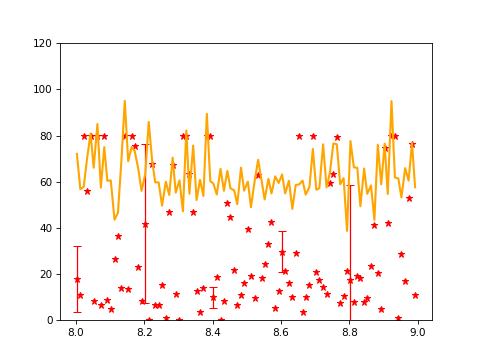

(0, 120)

In [14]:
fig, ax =plt.subplots()
ax.plot(iv_time, Ti , '*' , color = 'red')
plt.errorbar(iv_time, Ti, yerr=Ti_err, xerr=None, fmt='None', ecolor='red', elinewidth=1.2, capsize=4, barsabove=True, lolims=False, uplims=False, xlolims=False, xuplims=False, errorevery=20, capthick=None, )
ax.plot(iv_time ,(80 - np.array(Vfl))/1, color = 'orange', linewidth = 2)
ax.set_ylim(0, 120)

In [15]:
rel_err= 0.8
Ti_filt = []
Ti_err_filt = []
Vp_probe_filt = []
Vp_err_filt = []
time_filter = []
Isat_filter = []
i = 0
for i in range(0,len(Ti)):
    rules = [np.divide(Ti_err[i],Ti[i]) < rel_err ,
            np.divide(Vfl_err[i],Vfl[i]) < rel_err,
            Ti[i]<(80 - np.array(Vfl[i]))/1,
            Ti[i]<99,
            Ti_err[i]>0.0,
             ]
    if all(rules):
        Ti_filt.append(Ti[i])
        Ti_err_filt.append(Ti_err[i])
        Vp_probe_filt.append(Vfl[i])
        Vp_err_filt.append(Vfl_err[i])
        time_filter.append(iv_time[i])
        Isat_filter.append(I_sat[i])
print('nuber of succesful fits = '+ str(len(Ti_filt))+' / ' +str(len(Ti)))

nuber of succesful fits = 12 / 100


<IPython.core.display.Javascript object>


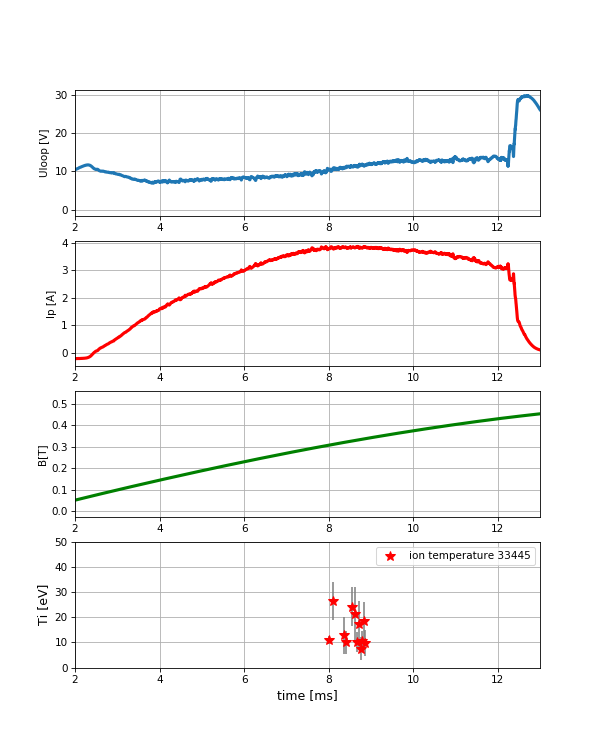

In [16]:
fig,ax = plt.subplots(4, figsize = (8,10))
ax[0].plot(Uloop.t,Uloop.V,linewidth = 3 ,)

ax[0].set_ylabel('Uloop [V]')
ax[0].set_xlim(2,13)
ax[0].grid()

ax[1].plot(Ip.t,Ip.I,linewidth = 3 ,color = 'red')
ax[1].set_ylabel('Ip [A]')
ax[1].set_xlim(2,13)
ax[1].grid()

ax[2].plot(Bt.t,Bt.B,linewidth = 3 , color = 'green')
ax[2].set_ylabel('B[T]')
ax[2].set_xlim(2,13)
ax[2].grid()


ax[3].plot(time_filter, Ti_filt, '*',markersize = 10 , color = 'red' , label ='ion temperature ' + str(shot_number))
ax[3].errorbar(time_filter, Ti_filt, yerr=Ti_err_filt, xerr=None, fmt='None', ecolor='gray', elinewidth=None, capsize=None, barsabove=True, lolims=False, uplims=False, xlolims=False, xuplims=False, errorevery=1, capthick=None, )
ax[3].set_ylim(0,50)
ax[3].set_xlim(2,13)
ax[3].legend(fontsize = 10)
ax[3].set_xlabel('time [ms]', fontsize = 12)
ax[3].set_ylabel('Ti [eV]', fontsize = 12)
#ax[3].set_yticks([0,5,10,15,20,30,40,50])
ax[3].grid()

fig.savefig('ALL_params_' + str(radial_probe_position ) +'mm_'+str(shot_number)+'.png' )

# Electron Temps

In [23]:
shot_number_float = '33446'
radial_probe_position = 65

# lp a bpp sonda
lp = pd.read_csv(urlopen('http://golem.fjfi.cvut.cz/shots/' + shot_number_float +'/DASs/PetiSonda/4-LPfloat.csv'),names = ['t','V'])
lp.t = 1e3*lp.t
time_ax_float = lp.t
lp_V = lp.V *178

## #offsetremoval
tt=1
time_ax_float =np.array(time_ax_float)
OffsetLP_float = np.mean(lp_V[10:nearest(time_ax, tt)])
print('ofset_lp: '+str(OffsetLP))
Vfl_LP = lp_V - OffsetLP_float

#BPP
# current_BPP_float = pd.read_csv(urlopen('http://golem.fjfi.cvut.cz/shots/' + shot_number_float +'/DASs/PetiSonda/2-BPPcur.csv'),names = ['t','I'])
# bpp_time_float = 1e3*current_BPP.t
# current_float = current_BPP_float.I/22 ##odpor bol 22 
voltage_BPP_float = pd.read_csv(urlopen('http://golem.fjfi.cvut.cz/shots/' + shot_number_float +'/DASs/PetiSonda/3-BPPvolt.csv'),names = ['t','V'])
BPP_time_float = 1e3*voltage_BPP_float.t
Vp_BPP_float = 178*voltage_BPP_float.V
OffsetBPP_float = np.mean(Vp_BPP_float[10:nearest(time_ax, tt)])
Vp_BPP = Vp_BPP_float - OffsetBPP_float
print('ofset_BPP: '+str(OffsetBPP_float))


ofset_lp: -0.8277686533301768
ofset_BPP: -1.2344650114425506


In [25]:
alpha

0.2381446545700001

In [60]:
lo = nearest(time_ax_float, 8)
hi = nearest(time_ax_float, 9)
Te =((Vp_BPP-Vfl_LP)/2.5)
times = time_ax_float[lo:hi]
Tes = Te.data[lo:hi]
V_p = Vp_BPP_float[lo:hi] + alpha*Tes
Te_smooth = lowpasss(times, Tes, 1)

D:\Programy\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Series.data is deprecated and will be removed in a future version
  """


In [61]:
np.mean(Vp_probe_filt)

25.382004212649832

In [62]:
np.mean(V_p)

16.931521893221966

<IPython.core.display.Javascript object>


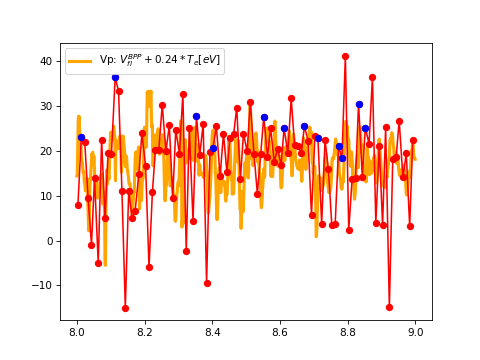

In [65]:

plt.figure()
plt.plot(times,V_p, linewidth = 3, color = 'orange', label = 'Vp: $V_{fl}^{BPP} +0.24 *T_e [eV]$')
plt.plot(iv_time,Vfl,'-o', linewidth = 1.5, color = 'red', label = '')
plt.plot(time_filter,Vp_probe_filt,'o', linewidth = 3, color = 'blue', label = '')
#plt.plot(time_filter,Ti_filt,'o', linewidth = 3, color = 'blue', label = '')

plt.legend()

<IPython.core.display.Javascript object>


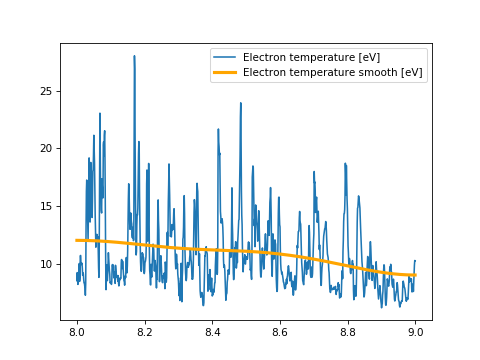

In [66]:
plt.figure()
plt.plot(times ,Tes, label = 'Electron temperature [eV]'  )
plt.plot(times,Te_smooth, linewidth = 3, color = 'orange', label = 'Electron temperature smooth [eV]')
plt.legend()

<IPython.core.display.Javascript object>


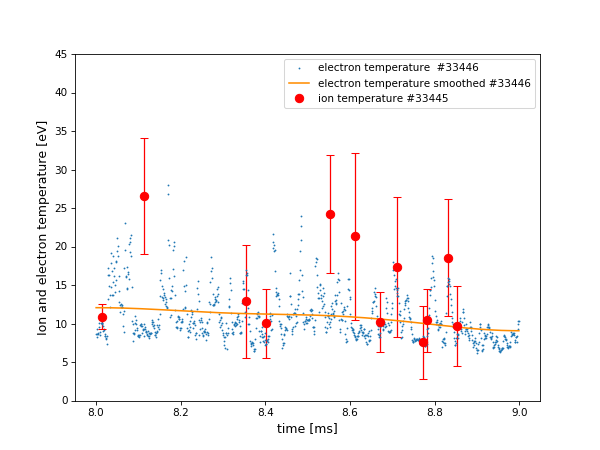

In [67]:
fig, ax = subplots(figsize= (8,6))
ax.plot(times, Tes, '.',markersize = 1.5,label = 'electron temperature  #'+ str(shot_number_float))
ax.plot(times, Te_smooth,color = 'darkorange', label = 'electron temperature smoothed #'+ str(shot_number_float))
ax.plot(time_filter, Ti_filt, 'o',markersize = 8 , color = 'red' , label ='ion temperature #' + str(shot_number))
plt.errorbar(time_filter, Ti_filt, yerr=Ti_err_filt, xerr=None, fmt='None', ecolor='red', elinewidth=1.2, capsize=4, barsabove=True, lolims=False, uplims=False, xlolims=False, xuplims=False, errorevery=1, capthick=None, )
#ax.set_xlim(-0.005,0.02)
ax.set_ylim(0,45)
ax.legend(fontsize = 10, loc = 'upper right')
ax.set_xlabel('time [ms]', fontsize = 12)
ax.set_ylabel('Ion and electron temperature [eV]', fontsize = 12)

fig.savefig('Ti_' + str(radial_probe_position ) +'mm_'+str(shot_number)+'.png' )

In [68]:
radial_probe_position

65

# Zober tam kde Te je konst tj 8-9 ms !!!

In [70]:
#$$$$$$$$$   ULOZENIE FILTERED DAT $$$$$$$###############
p_fil = np.ones(len(time_filter))
p_filt = p_fil-1 + radial_probe_position
from astropy.table import QTable, Table, Column
My_Temperatures = Table([time_filter, Ti_filt,Ti_err_filt, Vp_probe_filt,Vp_err_filt,  Isat_filter ,p_filt], names=['  t[ms] ', 'Ti[eV]', 'Ti_err[eV]', 'Vp_cut[V]','Vp_err[V]','Isat','Ti_norm_positions'])
ascii.write(My_Temperatures, 'Ti_BPP_profile_2ms_bin_averaged_Weighted_NewLP'+str(shot_number)+'.txt')

#$$$$$$$$$   ULOZENIE Te DAT $$$$$$$###############
Te_p_fil = np.ones(len(times))
Te_p_filt = Te_p_fil-1 + radial_probe_position
from astropy.table import QTable, Table, Column
Te_table = Table([times, Tes,Te_smooth,V_p, Te_p_filt], names=['t[ms] ', 'Te[eV]', 'Te_smooth','Plasma_potential', 'pos'])
ascii.write(Te_table, 'Te_'+str(shot_number)+'.txt')

In [ ]:
# time_start = 9.5
# time_end = 10
# iv_start = nearest(interval_pivots,time_start)
# iv_terminate = nearest(interval_pivots,time_end)
# j = iv_start
# resolution =  1 # radial temperature resolution. It is a multiplication constant! #############################1
# ###############################################################################################################
# Ti = []
# Vfl      = []
# R        = []
# I_sat    = []
# Ti_err   = []
# R_err    = []
# Vfl_err  = []
# I_sat_err= []
# index = []
# #R2arr    = []


# for j in range(iv_start,iv_terminate, 1):
#     iv_start = j
#     time_bin = 10                     # periods for deviation estimation

#     lobound = [0., 0., 0., -1.]       # fit lower bound for Ti, R, Vf, Isat
#     upbound = [150., 1, 80., 0.]    # fit upper bound for Ti, R, Vf, Isat


# # ------------------------------------------------------------------------------------------------------------

#     iv_stop  = iv_start + resolution #+ 1 perioda # LOL 

#     cut_err = (interval_pivots[iv_start-time_bin//2] < t) & (t < interval_pivots[iv_start+time_bin//2])
#     cut_dat = (interval_pivots[iv_start] < t) & (t < interval_pivots[iv_stop])

#     cut_V = (0 < V) & (V < 100)
#     cut_I = (I < 0.0)

#     I_short = I[cut_dat & cut_I & cut_V]
#     V_short = V[cut_dat & cut_I & cut_V]
#     I_long  = I[cut_err & cut_I & cut_V]
#     V_long  = V[cut_err & cut_I & cut_V]

# ##### Calculate the error bars from binned data and assign to raw data
#     try:
#         binsize = 5. # size of the voltage intervals for the calculation of the standard deviation
#         binned_data = bin_average(I_long, V_long, binsize) # Compute the standard deviations for each bin

#         verrs = binned_data['V_err'] # voltage stds
#         ierrs = binned_data['I_err'] # current stds
#         vbins = binned_data['V']     # un-center the bins
    

#         current_err = np.ones_like(I_short) # create an array of ones with the same size as I
#         voltage_err = np.ones_like(V_short) # which is also the size of V, so both are the same size

#         for i, vbin in enumerate(vbins): # iterate on the bins
#             current_err[V_short >= vbin] = ierrs[i] 
#             voltage_err[V_short >= vbin] = verrs[i]
            
            
#     except (RuntimeError,ValueError):  # for the graph is dark and full of errors
#         Ti.append(-10)
#         Ti_err.append(-10)
#         Vfl.append(-10)
#         R.append(-10)
#         I_sat.append(-10)
#         R_err.append(-10)
#         Vfl_err.append(-10)
#         I_sat_err.append(-10)
#         index.append(-10)
#         continue

#     try:  
#         popt2, pcov2 = curve_fit(ivchar_fit, V_short, I_short, bounds=(lobound, upbound), sigma=current_err, absolute_sigma=False)
#         rpopt2, rpcov2 = curve_fit(ivchar_fit, V_short, I_short, bounds=([0., 0., popt2[2]-10, -10.], [150., 1, popt2[2]+10, 10.]), sigma=current_err, absolute_sigma=False)
#         rrpopt2, rrpcov2 = curve_fit(ivchar_fit, V_short, I_short, bounds=([0., 0., rpopt2[2]-5, -10.], [150., 1, rpopt2[2]+5, 10.]), sigma=current_err, absolute_sigma=False)
        
        
#     except (RuntimeError,ValueError):  # for the graph is dark and full of errors
#         Ti.append(-10)
#         Ti_err.append(-10)
#         Vfl.append(-10)
#         R.append(-10)
#         I_sat.append(-10)
#         R_err.append(-10)
#         Vfl_err.append(-10)
#         I_sat_err.append(-10)
#         index.append(-10)
#        # R2arr.append(-10)

#         continue
        
#     rcut_V = ((rrpopt2[2] - 0.1*rrpopt2[2]) < V) & (V <  100)

#     rI_short = I[cut_dat & cut_I & rcut_V]
#     rV_short = V[cut_dat & cut_I & rcut_V]
#     rI_long  = I[cut_err & cut_I & rcut_V]
#     rV_long  = V[cut_err & cut_I & rcut_V]

# ##### Calculate the error bars from binned data and assign to raw data
#     try:
#         rbinned_data = bin_average(rI_long, rV_long, binsize) # Compute the standard deviations for each bin
#         rverrs = rbinned_data['V_err'] # voltage stds
#         rierrs = rbinned_data['I_err'] # current stds
#         rvbins = rbinned_data['V'] # un-center the bins
#         r_current_err = np.ones_like(rI_short) # create an array of ones with the same size as I
#         r_voltage_err = np.ones_like(rV_short) # which is also the size of V, so both are the same size

#         for i, rvbin in enumerate(rvbins): # iterate on the bins
#             r_current_err[rV_short >= rvbin] = rierrs[i] 
#             r_voltage_err[rV_short >= rvbin] = rverrs[i]
            
#     except (RuntimeError,ValueError):  # for the graph is dark and full of errors
#         Ti.append(-11)
#         Ti_err.append(-11)
#         Vfl.append(-11)
#         R.append(-11)
#         I_sat.append(-11)
#         R_err.append(-11)
#         Vfl_err.append(-11)
#         I_sat_err.append(-11)
#         index.append(-11)
#         continue
    
#     try:
#         cpopt2, cpcov2 = curve_fit(Afterburner(rrpopt2[2]), rV_short, rI_short, bounds=([0., 0., -1.], [150., 1, 0.]), sigma=r_current_err, absolute_sigma=False)
        
#         mean_of_data=(1/len(rI_short))*np.sum(-rI_short)  #######np.mean(-rI_short)########
#         SS_tott= np.sum((-rI_short-mean_of_data)**2)
#         SS_ress=np.sum((-rI_short+ivchar_fit_Weighted(rV_short, *cpopt2))**2)
#         R2_value = 1-(SS_ress/SS_tott)
        
        
#     except (RuntimeError,ValueError):  # for the graph is dark and full of errors
#         Ti.append(-11)
#         Ti_err.append(-11)
#         Vfl.append(-11)
#         R.append(-11)
#         I_sat.append(-11)
#         R_err.append(-11)
#         Vfl_err.append(-11)
#         I_sat_err.append(-11)
#         index.append(-11)
#         #R2arr.append(-11)

#         continue
        
#     try:
#         condition = (85-rrpopt2[2]) < 3*cpopt2[0] 
        
#         if condition :
#             boundss = ([0., -1.], [150., 0.])
#         else:
#             boundss = ([0., 0., -1.], [150., 1, 0.])
#         Ccrrpopt2, Ccrrpcov2 = q_curve_fit(boundss, Rzero(condition)(rrpopt2[2]), rV_short, rI_short, bounds=boundss, sigma= r_current_err, absolute_sigma=False)
        
#     except (RuntimeError,ValueError):  # for the graph is dark and full of errors
#         Ti.append(-12)
#         Ti_err.append(-12)
#         Vfl.append(-12)
#         R.append(-12)
#         I_sat.append(-12)
#         R_err.append(-12)
#         Vfl_err.append(-12)
#         I_sat_err.append(-12)
#         index.append(-11)
#        # R2arr.append(-12)

    
        
#     else:
#         Ti.append(Ccrrpopt2[0])
#         Ti_err.append(Ccrrpcov2[0])
#         R.append(Ccrrpopt2[1])
#         Vfl.append(rrpopt2[2])
#         I_sat.append(Ccrrpopt2[2])
#         R_err.append(Ccrrpcov2[1])
#         Vfl_err.append(np.sqrt(rrpcov2[2][2]))
#         I_sat_err.append(Ccrrpcov2[2])
#         index.append(iv_start)
#        # R2arr.append(R2_value)
        
#     fig, ax = plt.subplots(figsize = (8,6))
#     ax.set_title(str(shot_number)+' index: '+str(iv_start))
#     ax.plot(V_short, -I_short, color='k', Marker = 'o',alpha = 0.3, linestyle='None')
#     ax.plot(rV_short, -rI_short, color='k', label='data', Marker = 'o', linestyle='None')
# #ax.plot(vbins , -ibins , '*', label = 'bins through ' +str(time_bin)+' IVs')
# #ax.errorbar(vbins , -ibins ,ierrs)
#     x = np.linspace(np.nanmin(V_short) , np.nanmax(rV_short), num=len(rV_short)) ## noncutted IV
#     xx = np.linspace(rrpopt2[2]- 0.1*rrpopt2[2], np.nanmax(V_short), num=len(V_short))  ## cutted IV
#     ax.errorbar(V_short, -I_short, yerr=current_err, color='grey', label='sigma', Marker = '', linestyle='None')

#     ##### FIRST Fits  ###########
#     #ax.plot(x, -ivchar_fit(x, *rrpopt), color='blue', linewidth=4, alpha=.53 ,label='UNweighted_FF Ti = {0:4.2f} ± {1:4.2f} eV, Vfl = {2:4.2f} V, Isat = {3:4.2f} A'.format(rrpopt[0], np.sqrt(rrpcov[0][0]),rrpopt[2], -rrpopt[3]))
#     #ax.plot(x, -ivchar_fit(x, *rrpopt2), color='green', linewidth=4, alpha=.3, label='Weighted_FF Ti = {0:4.2f} ± {1:4.2f} eV, Vfl = {2:4.2f} V, Isat = {3:4.2f} A'.format(rrpopt2[0], np.sqrt(rrpcov2[0][0]),rrpopt2[2], -rrpopt2[3]))
#     ###################### Results of normal fits ########
#     ax.plot(xx, -ivchar_fit_Weighted(xx, *Ccrrpopt2),  color='red', linewidth=4, alpha=.5, 
#             label='Weighted Ti Rzero= {0:4.2f} ± {1:4.2f} eV, Vfl = {2:4.2f} ± {3:4.2f} V, Isat = {4:4.2f} A'.format(Ccrrpopt2[0], Ccrrpcov2[0], rrpopt2[2], np.sqrt(rrpcov2[2][2]) ,-Ccrrpopt2[2]))


#     ax.set_xlabel('Voltage [V]', fontsize=12)
#     ax.set_ylabel('Current [A]', fontsize=12)
#     ax.set_xlim(0,80)
#     ax.legend(loc='upper left', fontsize=8)